In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
import seaborn as sns
from model import loss
import tree
from model import reverse_se3_diffusion
from data import rosetta_data_loader
from data import digs_data_loader
from data import all_atom
from openfold.data import data_transforms
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation
from openfold.np import residue_constants

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

# Set environment variables for which GPUs to use.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
chosen_gpu = ''.join(
    [str(x) for x in GPUtil.getAvailable(order='memory')])
os.environ["CUDA_VISIBLE_DEVICES"] = chosen_gpu
print(f"Using GPU: {chosen_gpu}")

INFO: Using numpy backend


Using GPU: 


In [2]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(au)
importlib.reload(loss)
importlib.reload(reverse_se3_diffusion)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [3]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False
exp_conf.normalize_pred_score = True

data_conf = conf.data
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0
data_conf.digs.crop_len = None
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0
data_conf.digs.crop_len = None

diff_conf = conf.diffuser
diff_conf.diffuse_trans = True
diff_conf.diffuse_rot = True

diff_conf.rot_schedule = 'linear'
diff_conf.trans_schedule = 'exponential'

# print(OmegaConf.to_yaml(conf))

In [4]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Training: 18769 examples
INFO: Validation: 18769 examples


In [5]:
train_iter = iter(train_loader)
next_item = next(train_iter)

In [6]:
# Extract features
b_idx = 0
batch_item = tree.map_structure(lambda x: x[b_idx], next_item)
res_mask = batch_item['res_mask'].bool()

gt_rigids = ru.Rigid.from_tensor_7(batch_item['rigids_0'][res_mask])
gt_atom_pos37 = batch_item['atom_positions'][res_mask]
gt_aatype = batch_item['aatype'][res_mask]
gt_atom37_mask = batch_item['atom_mask'][res_mask]
gt_rigids = gt_rigids.apply_trans_fn(
    lambda x: x*exp._data_conf.scale_factor)

## Extract base atoms

In [9]:
# Compute idealized frames and inverted ideal positions
idealized_pos = torch.tensor(residue_constants.restype_atom14_rigid_group_positions)
idealized_frames = ru.Rigid.from_3_points(
    idealized_pos[:, 0],
    idealized_pos[:, 1],
    idealized_pos[:, 2]
)
idealized_rots = idealized_frames.get_rots()
inverted_idealized_pos = idealized_rots[:, None].invert_apply(idealized_pos)
inverted_idealized_bb_pos = torch.stack([
    inverted_idealized_pos[:, 0],  # N
    inverted_idealized_pos[:, 1],  # Ca
    inverted_idealized_pos[:, 2],  # C
    inverted_idealized_pos[:, 4],  # Cb
], dim=1)

In [10]:
def bb_rigids_to_ideal_pos(bb_rigids, aatype):
    ideal_bb_pos = inverted_idealized_bb_pos[aatype]
    bb_atoms = bb_rigids[:, None].apply(ideal_bb_pos)
    bb_atoms37 = torch.zeros(aatype.shape + (37, 3))
    bb_atoms37[..., :4, :] = bb_atoms
    return bb_atoms37

In [85]:
pred_pos37 = bb_rigids_to_ideal_pos(gt_rigids, aatype)

In [91]:
n_atoms = pred_pos37[:, 0]
c_atoms = pred_pos37[:, 2]
n_1_atoms = torch.roll(n_atoms, -1, dims=0)
print(np.mean(np.linalg.norm(c_atoms - n_1_atoms, axis=-1)[1:]))

1.4201452


In [ ]:
# Plotly
all_bb_3d = []
for i in range(4):
    sample_bb_3d = plotting.create_scatter(
        pred_bb_atom[:, i], mode='markers', marker_size=3, opacity=1.0, name=str(i))
    all_bb_3d.append(sample_bb_3d)
plotting.plot_traces(all_bb_3d)

In [90]:
au.write_prot_to_pdb(
    pred_pos37,
    './test.pdb'
)

'./test_1.pdb'

## Calculate null all-atoms

In [7]:
def torsion_angles_to_frames(
    r,
    alpha: torch.Tensor,
    aatype: torch.Tensor,
    rrgdf: torch.Tensor,
):
    # [*, N, 8, 4, 4]
    default_4x4 = rrgdf[aatype, ...]

    # [*, N, 8] transformations, i.e.
    #   One [*, N, 8, 3, 3] rotation matrix and
    #   One [*, N, 8, 3]    translation matrix
    default_r = r.from_tensor_4x4(default_4x4)

    bb_rot = alpha.new_zeros((*((1,) * len(alpha.shape[:-1])), 2))
    bb_rot[..., 1] = 1

    # [*, N, 8, 2]
    alpha = torch.cat(
        [bb_rot.expand(*alpha.shape[:-2], -1, -1), alpha], dim=-2
    )

    # [*, N, 8, 3, 3]
    # Produces rotation matrices of the form:
    # [
    #   [1, 0  , 0  ],
    #   [0, a_2,-a_1],
    #   [0, a_1, a_2]
    # ]
    # This follows the original code rather than the supplement, which uses
    # different indices.
    all_rots = alpha.new_zeros(default_r.get_rots().get_rot_mats().shape)
    all_rots[..., 0, 0] = 1
    all_rots[..., 1, 1] = alpha[..., 1]
    all_rots[..., 1, 2] = -alpha[..., 0]
    all_rots[..., 2, 1:] = alpha

    all_rots = ru.Rigid(ru.Rotation(rot_mats=all_rots), None)

    all_frames = default_r.compose(all_rots)

    chi2_frame_to_frame = all_frames[..., 5]
    chi3_frame_to_frame = all_frames[..., 6]
    chi4_frame_to_frame = all_frames[..., 7]

    chi1_frame_to_bb = all_frames[..., 4]
    chi2_frame_to_bb = chi1_frame_to_bb.compose(chi2_frame_to_frame)
    chi3_frame_to_bb = chi2_frame_to_bb.compose(chi3_frame_to_frame)
    chi4_frame_to_bb = chi3_frame_to_bb.compose(chi4_frame_to_frame)

    all_frames_to_bb = ru.Rigid.cat(
        [
            all_frames[..., :5],
            chi2_frame_to_bb.unsqueeze(-1),
            chi3_frame_to_bb.unsqueeze(-1),
            chi4_frame_to_bb.unsqueeze(-1),
        ],
        dim=-1,
    )

    all_frames_to_global = r[..., None].compose(all_frames_to_bb)

    return all_frames_to_global

In [8]:
# Constants
idealized_pos14 = torch.tensor(residue_constants.restype_atom14_rigid_group_positions)
idealized_pos37 = torch.tensor(residue_constants.restype_atom37_rigid_group_positions)
idealized_pos37_mask = (torch.sum(idealized_pos37, axis=-1) > 1e-5).bool()
default_frames = torch.tensor(residue_constants.restype_rigid_group_default_frame)
atom_mask = torch.tensor(residue_constants.restype_atom14_mask)
group_idx = torch.tensor(residue_constants.restype_atom14_to_rigid_group)

In [9]:
# Compute null rigid all atoms.
ideal_bb_frames = ru.Rigid.from_3_points(
    idealized_pos14[:, 0],
    idealized_pos14[:, 1],
    idealized_pos14[:, 2]
)
ideal_bb_rots = ideal_bb_frames.get_rots()

null_bb_pos = ideal_bb_rots[:, None].invert_apply(idealized_pos14)
null_torsions = torch.zeros((21, 7, 2))
null_aatype = torch.arange(21)

prot_feats = {
    'aatype': null_aatype,
    'all_atom_positions': idealized_pos37,
    'all_atom_mask': idealized_pos37_mask,
}
ideal_torsions = data_transforms.atom37_to_torsion_angles()(prot_feats)['torsion_angles_sin_cos']

ideal_frames = torsion_angles_to_frames(
    ideal_bb_frames,
    ideal_torsions,
    #torch.zeros_like(idealized_torsions),  # This needs to be idealized torsions
    null_aatype,
    default_frames)
ideal_rots = ideal_frames.get_rots()


In [10]:
# [21, 14, 4, 4]
null_default_4x4 = default_frames[null_aatype, ...]
# [21, 14]
null_group_mask = group_idx[null_aatype, ...]
# [21, 14, 8]
null_group_mask = torch.nn.functional.one_hot(
    null_group_mask,
    num_classes=null_default_4x4.shape[-3],
)

# [21, 14, 8]
null_rot_to_global = ideal_rots[..., None, :] * null_group_mask
# [21, 14]
null_rot_to_global = null_rot_to_global.map_tensor_fn(
    lambda x: torch.sum(x, dim=-1)
)
# [21, 14, 1]
null_atom_mask = atom_mask[null_aatype, ...].unsqueeze(-1)
# [21, 14, 3]
null_global_pos = null_rot_to_global.invert_apply(idealized_pos14)
null_global_pos = null_global_pos * null_atom_mask

In [11]:
def frames_to_atom14_pos(
    r,
    aatype,
):
    # [*, N, 14, 4, 4]
    default_4x4 = default_frames[aatype, ...]

    # [*, N, 14]
    group_mask = group_idx[aatype, ...]

    # [*, N, 14, 8]
    group_mask = torch.nn.functional.one_hot(
        group_mask,
        num_classes=default_frames.shape[-3],
    )

    # [*, N, 14, 8]
    t_atoms_to_global = r[..., None, :] * group_mask

    # [*, N, 14]
    t_atoms_to_global = t_atoms_to_global.map_tensor_fn(
        lambda x: torch.sum(x, dim=-1)
    )

    # [*, N, 14, 1]
    frame_atom_mask = atom_mask[aatype, ...].unsqueeze(-1)

    # [*, N, 14, 3]
    frame_null_pos = null_global_pos[aatype, ...]
    pred_positions = t_atoms_to_global.apply(frame_null_pos)
    pred_positions = pred_positions * frame_atom_mask

    return pred_positions

In [13]:
# Test we can recover the idealized positions
pred_frames = ru.Rigid.from_3_points(
    null_global_pos[:, 0],
    null_global_pos[:, 1],
    null_global_pos[:, 2]
)

pred_all_frames = torsion_angles_to_frames(
    pred_frames,
    ideal_torsions,
    null_aatype,
    default_frames
)

pred_atom14 = frames_to_atom14_pos(
    pred_all_frames,
    null_aatype,
)


In [14]:
pred_atom14[0]

tensor([[-1.4606e+00,  5.9605e-08,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 5.4850e-01,  1.4240e+00,  0.0000e+00],
        [ 7.6034e-01,  9.6682e-01,  0.0000e+00],
        [ 5.3213e-01, -7.7185e-01, -1.2050e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [15]:
idealized_pos14[0]

tensor([[-0.5250,  1.3630,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.5260, -0.0000, -0.0000],
        [ 0.6270,  1.0620,  0.0000],
        [-0.5290, -0.7740, -1.2050],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [48]:
# Test that this returns close to GT atoms

# Extract torsion angles
prot_feats = {
    'aatype': gt_aatype,
    'all_atom_positions': gt_atom_pos37,
    'all_atom_mask': gt_atom37_mask,
}
torsion_angles_feats = data_transforms.atom37_to_torsion_angles()(prot_feats)

In [49]:
gt_torsions = torsion_angles_feats['torsion_angles_sin_cos']
gt_torsion_mask = torsion_angles_feats['torsion_angles_mask']

# Calculate GT frames
gt_all_frames = torsion_angles_to_frames(
    gt_rigids,
    gt_torsions, # * gt_torsion_mask[..., None],
    gt_aatype,
    default_frames
)

pred_atom14 = frames_to_atom14_pos(
    gt_all_frames,
    gt_aatype,
)

In [50]:
pred_bb_atom = pred_atom14[:, :5]
pred_bb_atom[:3, 3]
# pred_bb_atom[1, 0]

tensor([[ -9.5079,  -2.0346, -17.5646],
        [ -6.1304,  -0.3544, -17.3110],
        [ -5.2293,   3.2029, -16.4705]])

In [45]:
gt_bb_atom = gt_atom_pos37[:, :5]
gt_bb_atom[:3, 4]
# gt_bb_atom[1, 0]

tensor([[ -6.2136,  -1.8817, -16.8926],
        [ -6.5666,   2.9463, -18.1516],
        [ -2.9506,   3.7953, -18.9126]], dtype=torch.float64)

In [23]:
# gt_torsions = torch.zeros_like(gt_torsions)
# gt_torsion_mask = torsion_angles_feats['torsion_angles_mask']

# # Calculate GT frames
# gt_all_frames = torsion_angles_to_frames(
#     gt_rigids,
#     gt_torsions, # * gt_torsion_mask[..., None],
#     gt_aatype,
#     default_frames
# )
# gt_all_frames[0, 3].to_tensor_7()

In [24]:
pred_atom14 = frames_to_atom14_pos(
    gt_all_frames,
    gt_aatype,
)

In [25]:
pred_bb_atom = pred_atom14[:, :5]
pred_bb_atom[:3, 3]
# pred_bb_atom[1, 0]

tensor([[ -8.4762,  -1.1279, -16.3958],
        [ -5.2776,   0.9152, -18.2565],
        [ -4.1482,   4.6078, -16.8023]])

In [26]:
gt_bb_atom = gt_atom_pos37[:, :5]
gt_bb_atom[:3, 4]
# gt_bb_atom[1, 0]

tensor([[ -6.2136,  -1.8817, -16.8926],
        [ -6.5666,   2.9463, -18.1516],
        [ -2.9506,   3.7953, -18.9126]], dtype=torch.float64)

In [ ]:
# bb_atom14 = ['N', 'CA', 'C', 'O', 'CB']
# bb_atom37 = ['N', 'CA', 'C', 'CB', 'O']

## Test library

In [43]:
importlib.reload(all_atom)

<module 'data.all_atom' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/data/all_atom.py'>

In [44]:
# Test we can recover the idealized positions
pred_all_frames = all_atom.torsion_angles_to_frames(
    all_atom.IDEALIZED_FRAMES,
    all_atom.IDEALIZED_TORSION,
    all_atom.ALL_AATYPE,
)

pred_atom14 = all_atom.frames_to_atom14_pos(
    pred_all_frames,
    all_atom.ALL_AATYPE,
)


In [47]:
pred_atom14[1]

tensor([[-5.2400e-01,  1.3620e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.5250e+00, -5.9605e-08,  0.0000e+00],
        [ 6.2600e-01,  1.0620e+00,  0.0000e+00],
        [-5.2400e-01, -7.7800e-01, -1.2090e+00],
        [ 6.1600e-01,  1.3900e+00,  0.0000e+00],
        [ 5.6400e-01,  1.4140e+00, -3.5763e-06],
        [ 5.3899e-01,  1.3570e+00, -1.0014e-05],
        [ 7.5799e-01,  1.0930e+00, -5.4836e-06],
        [ 2.0600e-01,  2.3010e+00, -5.7220e-06],
        [ 2.0780e+00,  9.7800e-01, -7.2718e-06],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [48]:
all_atom.IDEALIZED_POS[1]

tensor([[-0.5240,  1.3620, -0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.5250, -0.0000, -0.0000],
        [ 0.6260,  1.0620,  0.0000],
        [-0.5240, -0.7780, -1.2090],
        [ 0.6160,  1.3900, -0.0000],
        [ 0.5640,  1.4140,  0.0000],
        [ 0.5390,  1.3570, -0.0000],
        [ 0.7580,  1.0930, -0.0000],
        [ 0.2060,  2.3010,  0.0000],
        [ 2.0780,  0.9780, -0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [7]:
# Test that this returns close to GT atoms

# Extract torsion angles
prot_feats = {
    'aatype': gt_aatype,
    'all_atom_positions': gt_atom_pos37,
    'all_atom_mask': gt_atom37_mask,
}
torsion_angles_feats = data_transforms.atom37_to_torsion_angles()(prot_feats)
gt_torsions = torsion_angles_feats['torsion_angles_sin_cos']
# gt_torsions = torch.tile(gt_torsions[:, 4][:, None], (1, 7, 1))
gt_torsion_mask = torsion_angles_feats['torsion_angles_mask']

# Calculate GT frames
gt_all_frames = all_atom.torsion_angles_to_frames(
    gt_rigids,
    gt_torsions,
    gt_aatype
)

In [8]:
pred_atom14 = all_atom.frames_to_atom14_pos(
    gt_all_frames,
    gt_aatype,
)

In [17]:
pred_bb_atom = pred_atom14[:, :5]
pred_bb_atom[0, 3]
# pred_bb_atom[0, 4]

tensor([18.6683,  2.7105, -6.8771])

In [16]:
gt_bb_atom = gt_atom_pos37[:, :5]
gt_bb_atom[0, 4]
# gt_bb_atom[0, 3]

tensor([19.3551,  0.2003, -6.5447], dtype=torch.float64)

In [ ]:
# bb_atom14 = ['N', 'CA', 'C', 'O', 'CB']
# bb_atom37 = ['N', 'CA', 'C', 'CB', 'O']

## Working

In [ ]:
# Compute idealized frames and inverted ideal positions
idealized_pos = torch.tensor(residue_constants.restype_atom14_rigid_group_positions)
idealized_frames = ru.Rigid.from_3_points(
    idealized_pos[:, 0],
    idealized_pos[:, 1],
    idealized_pos[:, 2]
)
idealized_rots = idealized_frames.get_rots()
inverted_idealized_pos = idealized_rots[:, None].invert_apply(idealized_pos)
inverted_idealized_bb_pos = torch.stack([
    inverted_idealized_pos[:, 0],  # N
    inverted_idealized_pos[:, 1],  # Ca
    inverted_idealized_pos[:, 2],  # C
    inverted_idealized_pos[:, 4],  # Cb
    inverted_idealized_pos[:, 3],  # O
], dim=1)

In [ ]:
# [*, N, 14, 8]
null_rot_to_global = null_rots * null_group_mask

In [ ]:
inverted_idealized_pos = idealized_rots[:, None].invert_apply(idealized_pos)

In [ ]:
# [*, N, 14, 4, 4]
default_4x4 = default_frames[aatype, ...]
# [*, N, 14]
group_mask = group_idx[aatype, ...]
# [*, N, 14, 8]
group_mask = nn.functional.one_hot(
    group_mask,
    num_classes=default_frames.shape[-3],
)
# [*, N, 14, 8]
t_atoms_to_global = r[..., None, :] * group_mask

# [*, N, 14]
t_atoms_to_global = t_atoms_to_global.map_tensor_fn(
    lambda x: torch.sum(x, dim=-1)
)

# [*, N, 14, 1]
atom_mask = atom_mask[aatype, ...].unsqueeze(-1)

# [*, N, 14, 3]
lit_positions = lit_positions[aatype, ...]
pred_positions = t_atoms_to_global.apply(lit_positions)
pred_positions = pred_positions * atom_mask

In [ ]:
atom_mask = torch.tensor(residue_constants.restype_atom14_mask)
group_idx = torch.tensor(residue_constants.restype_atom14_to_rigid_group)
null_pos = frames_and_literature_positions_to_atom14_pos(
    null_frames,
    torch.arange(21),
    group_idx,
    atom_mask,
    default_frames,
    idealized_pos
)

In [27]:
def frames_and_literature_positions_to_atom14_pos(
    r,
    aatype,
    default_frames,
    group_idx,
    atom_mask,
    lit_positions,
):
    # [*, N, 14, 4, 4]
    default_4x4 = default_frames[aatype, ...]

    # [*, N, 14]
    group_mask = group_idx[aatype, ...]

    # [*, N, 14, 8]
    group_mask = nn.functional.one_hot(
        group_mask,
        num_classes=default_frames.shape[-3],
    )

    # [*, N, 14, 8]
    t_atoms_to_global = r[..., None, :] * group_mask

    # [*, N, 14]
    t_atoms_to_global = t_atoms_to_global.map_tensor_fn(
        lambda x: torch.sum(x, dim=-1)
    )

    # [*, N, 14, 1]
    atom_mask = atom_mask[aatype, ...].unsqueeze(-1)

    # [*, N, 14, 3]
    lit_positions = lit_positions[aatype, ...]
    pred_positions = t_atoms_to_global.apply(lit_positions)
    pred_positions = pred_positions * atom_mask

    return pred_positions

In [ ]:
inverted_idealized_bb_pos = torch.stack([
    inverted_idealized_pos[:, 0],  # N
    inverted_idealized_pos[:, 1],  # Ca
    inverted_idealized_pos[:, 2],  # C
    inverted_idealized_pos[:, 4],  # Cb
    inverted_idealized_pos[:, 3],  # O
], dim=1)

In [11]:
# Calculate all frames
all_frames = torsion_angles_to_frames(
    gt_rigids,
    gt_torsions, # * torsion_mask[..., None],
    aatype,
    rrgdf
)

In [74]:
# Compute idealized frames and inverted ideal positions
idealized_pos = torch.tensor(residue_constants.restype_atom14_rigid_group_positions)
idealized_frames = ru.Rigid.from_3_points(
    idealized_pos[:, 0],
    idealized_pos[:, 1],
    idealized_pos[:, 2]
)
idealized_rots = idealized_frames.get_rots()
inverted_idealized_pos = idealized_rots[:, None].invert_apply(idealized_pos)
inverted_idealized_bb_pos = torch.stack([
    inverted_idealized_pos[:, 0],  # N
    inverted_idealized_pos[:, 1],  # Ca
    inverted_idealized_pos[:, 2],  # C
    inverted_idealized_pos[:, 4],  # Cb
    inverted_idealized_pos[:, 3],  # O
], dim=1)

In [84]:
null_rots[0, 0].get_rot_mats()

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
        [-2.0404e-08,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [82]:
idealized_rots.shape

torch.Size([21])

In [81]:
idealized_rots[0].get_rot_mats()

tensor([[ 0.3594,  0.9332,  0.0000],
        [-0.9332,  0.3594,  0.0000],
        [ 0.0000, -0.0000,  1.0000]])

In [15]:
inverted_ideal_bb_pos = inverted_idealized_bb_pos[aatype]
base_atoms = all_frames[:, :1].apply(inverted_ideal_bb_pos)[:, :4]
omega_atoms = all_frames[:, 3:4].apply(inverted_ideal_bb_pos)[:, 4][:, None]
bb_atoms = torch.concat([base_atoms, omega_atoms], axis=1)

In [18]:
bb_atoms[0]

tensor([[  3.9245, -21.6924,   1.5472],
        [  3.0134, -20.9740,   2.4336],
        [  3.2171, -19.4671,   2.3180],
        [  3.2110, -21.4187,   3.8838],
        [  3.1344, -19.8433,   2.8867]])

In [17]:
gt_atom_pos37[0, :5]

tensor([[  3.9238, -21.6919,   1.5479],
        [  3.0134, -20.9740,   2.4336],
        [  3.1910, -19.4599,   2.3427],
        [  3.2129, -21.4335,   3.8828],
        [  4.2413, -18.9740,   1.9429]], dtype=torch.float64)

In [292]:
# ideal_bb_pos = idealized_pos[aatype]
inverted_ideal_bb_pos = inverted_idealized_bb_pos[aatype]
inverted_ideal_bb_pos.shape

torch.Size([99, 5, 3])

In [255]:
base_atoms = all_frames[:, :1].apply(inverted_ideal_bb_pos)[:, :4]
omega_atoms = all_frames[:, 3:4].apply(inverted_ideal_bb_pos)[:, 4][:, None]
bb_atoms = torch.concat([base_atoms, omega_atoms], axis=1)

In [256]:
# all_frames[:, 3].apply(inverted_ideal_bb_pos[:, 4])[1]
# all_frames[:, 3].apply(ideal_bb_pos[:, 3])[1]

In [288]:
ideal_pos = idealized_pos[aatype][0][:5]
gt_pos = gt_atom_pos37[0, :5]
tmp = torch.clone(gt_pos[4])
gt_pos[4] = gt_pos[3]
gt_pos[3] = tmp

In [289]:
gt_pos[:5]

tensor([[-1.4655, 10.2809,  5.6884],
        [-1.5245,  9.2079,  6.7284],
        [-0.3435,  8.2599,  6.5054],
        [-2.8765,  8.4229,  6.6644],
        [-2.8765,  8.4229,  6.6644]], dtype=torch.float64)

In [ ]:
gt_atom_pos37[:5]

In [281]:
gt_pos.shape

torch.Size([5, 3])

In [263]:
bb_atoms.shape

torch.Size([99, 5, 3])

In [266]:
placeholder = torch.zeros((99, 37, 3))
placeholder[:, :5] = bb_atoms

In [268]:
au.write_prot_to_pdb(
    du.move_to_np(placeholder),
    './test.pdb'
)

'./test_4.pdb'

In [270]:
au.write_prot_to_pdb(
    du.move_to_np(gt_atom_pos37),
    './test.pdb'
)

'./test_6.pdb'

In [261]:
bb_atoms[0]

tensor([[-1.4669, 10.2549,  5.7136],
        [-1.5245,  9.2079,  6.7284],
        [-0.3592,  8.2395,  6.5387],
        [-2.8663,  8.4433,  6.6796],
        [-1.2833,  8.0359,  6.5969]])

In [262]:
gt_atom_pos37[0, :5]

tensor([[-1.4655, 10.2809,  5.6884],
        [-1.5245,  9.2079,  6.7284],
        [-0.3435,  8.2599,  6.5054],
        [-2.8765,  8.4229,  6.6644],
        [-0.0265,  7.9779,  5.3724]], dtype=torch.float64)

In [ ]:
# bb_atom14 = ['N', 'CA', 'C', 'O', 'CB']
# bb_atom37 = ['N', 'CA', 'C', 'CB', 'O']

In [ ]:
def bb_rigids_to_ideal_pos(bb_rigids, aatype):
    ideal_bb_pos = inverted_idealized_bb_pos[aatype]
    bb_atoms = bb_rigids[:, None].apply(ideal_bb_pos)
    bb_atoms37 = torch.zeros(aatype.shape + (37, 3))
    bb_atoms37[..., :4, :] = bb_atoms
    return bb_atoms37

In [132]:
def frames_and_literature_positions_to_atom14_pos(
    r: Rigid,
    aatype: torch.Tensor,
    default_frames,
    group_idx,
    atom_mask,
    lit_positions,
):
    # [*, N, 14, 4, 4]
    default_4x4 = default_frames[aatype, ...]

    # [*, N, 14]
    group_mask = group_idx[aatype, ...]

    # [*, N, 14, 8]
    group_mask = nn.functional.one_hot(
        group_mask,
        num_classes=default_frames.shape[-3],
    )

    # [*, N, 14, 8]
    t_atoms_to_global = r[..., None, :] * group_mask

    # [*, N, 14]
    t_atoms_to_global = t_atoms_to_global.map_tensor_fn(
        lambda x: torch.sum(x, dim=-1)
    )

    # [*, N, 14, 1]
    atom_mask = atom_mask[aatype, ...].unsqueeze(-1)

    # [*, N, 14, 3]
    lit_positions = lit_positions[aatype, ...]
    pred_positions = t_atoms_to_global.apply(lit_positions)
    pred_positions = pred_positions * atom_mask

    return pred_positions

torch.Size([99, 8])

In [ ]:
# Compute idealized frames and inverted ideal positions
idealized_pos = torch.tensor(residue_constants.restype_atom14_rigid_group_positions)
idealized_frames = ru.Rigid.from_3_points(
    idealized_pos[:, 0],
    idealized_pos[:, 1],
    idealized_pos[:, 2]
)
idealized_rots = idealized_frames.get_rots()
inverted_idealized_pos = idealized_rots[:, None].invert_apply(idealized_pos)
inverted_idealized_bb_pos = torch.stack([
    inverted_idealized_pos[:, 0],  # N
    inverted_idealized_pos[:, 1],  # Ca
    inverted_idealized_pos[:, 2],  # C
    inverted_idealized_pos[:, 4],  # Cb
], dim=1)

In [ ]:
pred_pos37.shape

In [57]:
n_atoms = pred_pos37[:, 0]
c_atoms = pred_pos37[:, 2]
n_1_atoms = torch.roll(n_atoms, -1, dims=0)
print(np.mean(np.linalg.norm(c_atoms - n_1_atoms, axis=-1)[1:]))

1.4201452


In [47]:
pred_bb_atom.shape

torch.Size([99, 4, 3])

In [ ]:
# Plotly
all_bb_3d = []
for i in range(4):
    sample_bb_3d = plotting.create_scatter(
        pred_bb_atom[:, i], mode='markers', marker_size=3, opacity=1.0, name=str(i))
    all_bb_3d.append(sample_bb_3d)
plotting.plot_traces(all_bb_3d)

In [ ]:
n_atoms = bb_atom14[:, 0]
c_atoms = bb_atom14[:, 2]
n_1_atoms = torch.roll(n_atoms, -1, dims=0)
print(np.mean(np.linalg.norm(c_atoms - n_1_atoms, axis=-1)[1:]))

In [108]:
restype_atom14_rigid_group_positions = residue_constants.restype_atom14_rigid_group_positions
rigid_to_atom = restype_atom14_rigid_group_positions[aatype]
# restype_atom37_rigid_group_positions = residue_constants.restype_atom37_rigid_group_positions
# rigid_to_atom = restype_atom37_rigid_group_positions[aatype]
bb_atom14 = gt_rigids[..., None].apply(rigid_to_atom)

In [110]:
restype_atom14_rigid_group_positions.shape

(21, 14, 3)

In [95]:
lit_heavy_atoms = np.array(rigid_to_atom[0][:3])
print(lit_heavy_atoms)

[[-0.529  1.36  -0.   ]
 [ 0.     0.     0.   ]
 [ 1.525 -0.    -0.   ]]


In [96]:
gt_heavy_atoms = du.move_to_np(gt_atom_pos37[0][:3])
gt_heavy_atoms = gt_heavy_atoms - gt_heavy_atoms[1, :][None]
gt_heavy_atoms

array([[-0.29199982,  1.46199989, -0.04099989],
       [ 0.        ,  0.        ,  0.        ],
       [-0.58399963, -0.60300064, -1.25299978]])

In [ ]:
# Plotly
lit_bb_3d = plotting.create_scatter(
    lit_heavy_atoms, mode='lines+markers', marker_size=3, opacity=1.0, name='lit')
gt_bb_3d = plotting.create_scatter(
    gt_heavy_atoms, mode='lines+markers', marker_size=3, opacity=1.0, name='gt')
plotting.plot_traces([lit_bb_3d, gt_bb_3d])

In [107]:
transformed_lit, R, t, reflection = du.rigid_transform_3D(lit_heavy_atoms, gt_heavy_atoms)

det(R) < R, reflection detected!, correcting for it ...


In [ ]:
# Plotly
lit_bb_3d = plotting.create_scatter(
    transformed_lit, mode='lines+markers', marker_size=3, opacity=1.0, name='lit')
gt_bb_3d = plotting.create_scatter(
    gt_heavy_atoms, mode='lines+markers', marker_size=3, opacity=1.0, name='gt')
plotting.plot_traces([lit_bb_3d, gt_bb_3d])

In [100]:
R

array([[-0.37313182, -0.33971679,  0.86334532],
       [-0.43777149,  0.88491489,  0.1590024 ],
       [-0.81800292, -0.31861911, -0.47890823]])

In [103]:
gt_rigids[0].get_rots().get_rot_mats()

tensor([[ 0.1958, -0.4651,  0.8633],
        [-0.9803, -0.1175,  0.1590],
        [ 0.0275, -0.8774, -0.4789]])

In [64]:
n_atoms = bb_atom14[:, 0]
c_atoms = bb_atom14[:, 2]
n_1_atoms = torch.roll(n_atoms, -1, dims=0)
print(np.mean(np.linalg.norm(c_atoms - n_1_atoms, axis=-1)[1:]))

3.841561


In [65]:
np.linalg.norm(c_atoms - n_1_atoms, axis=-1)[1:-1]

array([2.303036 , 2.537033 , 2.5263135, 2.6694305, 2.6375859, 2.6579049,
       2.6360335, 4.517839 , 2.938303 , 2.6434772, 3.8515635, 3.8697674,
       2.5956886, 2.690506 , 2.5799239, 2.3969874, 2.8545103, 2.7437387,
       3.7561011, 3.733092 , 3.7100108, 3.8364956, 3.7235909, 3.9176397,
       3.8161192, 4.2673903, 3.8324435, 3.7432697, 3.7386093, 3.8305194,
       3.7787533, 3.703727 , 3.9786668, 3.575627 , 2.7652764, 4.1343117,
       3.460295 , 3.4982934, 3.6722872, 4.284494 , 3.792689 , 4.5985665,
       2.7605398, 2.566919 , 2.541701 , 2.8478298, 3.768873 , 3.7931235,
       4.017823 , 3.2341104, 3.6581414, 2.9235253, 3.9820669, 3.3788455,
       4.096928 , 3.7435472, 4.218811 , 4.2955384, 2.7516804, 4.358937 ,
       2.8214056, 2.6767964, 2.6672158, 2.8475096, 3.5333436, 3.8337595,
       3.8000667, 3.7174163, 3.8218966, 3.7367868, 3.8695939, 3.7776365,
       4.25324  , 3.4950237, 3.1412287, 4.0663056, 2.3218095, 4.5305333,
       2.7677681, 3.7359962, 3.6842716, 3.882018 , 

In [66]:
n_atoms = gt_atom_pos37[:, 0]
c_atoms = gt_atom_pos37[:, 2]
n_1_atoms = torch.roll(n_atoms, -1, dims=0)
print(np.mean(np.linalg.norm(c_atoms - n_1_atoms, axis=-1)[1:-1]))

1.3307208180809065


In [67]:
np.linalg.norm(c_atoms - n_1_atoms, axis=-1)[1:]

array([ 1.32151265,  1.33748459,  1.33471837,  1.33920363,  1.33643749,
        1.32075676,  1.3367944 ,  1.33206787,  1.33052013,  1.33005009,
        1.33174588,  1.33061239,  1.34885817,  1.32090349,  1.32437685,
        1.33014583,  1.33062543,  1.33118571,  1.32702487,  1.33098456,
        1.33449034,  1.33377554,  1.3229761 ,  1.32714233,  1.32885368,
        1.32790549,  1.33135059,  1.32667468,  1.33174963,  1.33024435,
        1.32585857,  1.33112575,  1.3298382 ,  1.33737689,  1.33182014,
        1.33244677,  1.33023697,  1.33871029,  1.35298296,  1.3294137 ,
        1.3317526 ,  1.32828509,  1.34271884,  1.32132517,  1.32988132,
        1.32622204,  1.3260111 ,  1.33236772,  1.32474246,  1.32484023,
        1.32510264,  1.34367534,  1.32751265,  1.33328362,  1.33342396,
        1.33133035,  1.329336  ,  1.33292872,  1.32065684,  1.33504028,
        1.33541407,  1.31798448,  1.3269817 ,  1.3353239 ,  1.32377379,
        1.32434745,  1.32504702,  1.33519223,  1.33044426,  1.33

In [47]:
np.mean(np.linalg.norm(bb_atom14[0, :, :3] - gt_atom_pos37[0, :, :3], axis=-1))

RuntimeError: The size of tensor a (14) must match the size of tensor b (37) at non-singleton dimension 0

In [23]:
# bb_atom14 = ['N', 'CA', 'C', 'O', 'CB']
# bb_atom37 = ['N', 'CA', 'C', 'CB', 'O']

In [9]:
bb_atom14

torch.Size([16, 260, 5, 3])

In [11]:
np.mean(np.linalg.norm(bb_atom14[0, :, :3] - gt_atom_pos37[0, :, :3], axis=-1))

0.7515541097534891

In [36]:
gt_atom_pos37[0, 50, :3]

tensor([[  1.4630, -16.0782,   1.7241],
        [  1.6010, -17.1642,   2.6851],
        [  3.0240, -17.5712,   3.0661]], dtype=torch.float64)

In [55]:
gt_atom_pos37.shape

torch.Size([16, 260, 37, 3])

In [44]:
bb_atoms = gt_rigids[..., None].apply(rigid_to_atom)[..., :5, :]

In [45]:
bb_atoms.shape

torch.Size([16, 260, 5, 3])

In [30]:
aatype.shape

torch.Size([16, 260])

In [19]:
# Load model
inference_conf_path = '../config/inference.yaml'
inference_conf = OmegaConf.load(inference_conf_path)
inference_conf.ckpt_dir = '../pkl_jar/ckpt/subset_100_05D_09M_2022Y_20h_17m_53s'
inference_conf.default_conf_path = '../config/base.yaml'
inference_conf.output_dir = '../results'

print(OmegaConf.to_yaml(inference_conf))

# Set up sampler
sampler = inference_se3_diffusion.Sampler(inference_conf)

ckpt_dir: ../pkl_jar/ckpt/subset_100_05D_09M_2022Y_20h_17m_53s
output_dir: ../results
default_conf_path: ../config/base.yaml
samples_per_length: 10
sequence_length_range:
- 80
- 120
- 200
add_noise: true



In [21]:
# Run sampler
batch_size = 16
num_res = 100
save = True
samples_traj = sampler.sample(batch_size, num_res, save=save)

In [34]:
# Calculate Ca-Ca bond stats for each sample
b_idx = 0
final_sample = samples_traj[b_idx, -1]
final_sample_ca_pos = du.move_to_np(final_sample[:, 4:]) * sampler.scale_factor
ca_bond_dists = np.linalg.norm(final_sample_ca_pos - np.roll(final_sample_ca_pos, 1, axis=0), axis=-1)[1:]
ca_bond_dist_mean = np.mean(ca_bond_dists)
ca_bond_dist_std = np.std(ca_bond_dists)
ca_bond_dist_div = np.mean(ca_bond_dists - 3.8)

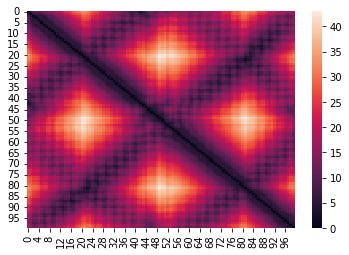

In [27]:
dist_mat = np.linalg.norm(final_sample_ca_pos[None] - final_sample_ca_pos[:, None], axis=-1)
ax = sns.heatmap(dist_mat)

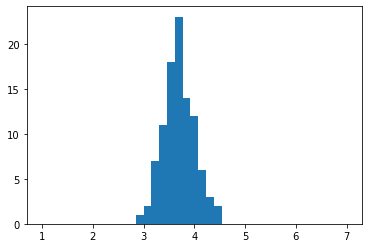

In [28]:
bins = np.linspace(1, 7, 40)
_ = plt.hist(bond_dists, bins=bins)

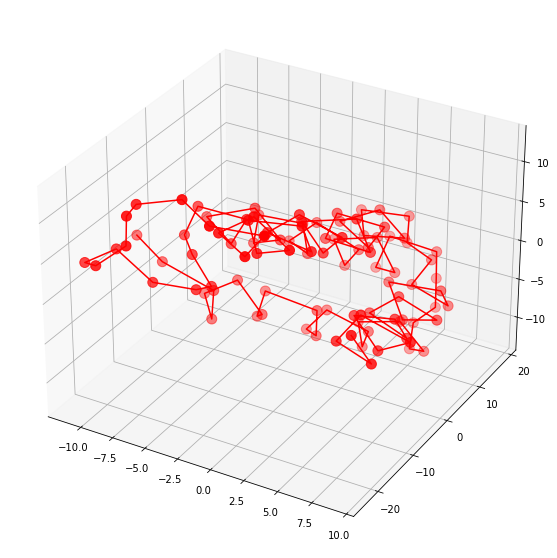

In [23]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(final_sample_ca_pos, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(final_sample_ca_pos, ax, color='r', mode='line')
# plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
# plotting.plt_3d(gt_ca, ax, color='b', mode='line')